In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from fitFunctions import *
from partialfitting import *
from tqdm import *
from fitphases import *
from chi2 import *
from corr2Pi import *

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
sigma_arr = [1e-5, 1e-3, 1e-1]
for i in range(10):
    sigma = 1e-5
    times = np.arange( 1, 500*1000, 1 )/1000
    sig = 0.39770392*np.sin(2*np.pi*1.554*times)
    sig = sig + np.random.normal(0, sigma, size=len(sig))
    np.savetxt('/home/jean/RomalisResearch/pulsed_fitter_current/OneFreq/FakeData/fakedata'+str(i)+".txt", sig)

In [4]:
#dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
dirName = "/home/jean/RomalisResearch/pulsed_fitter_current/OneFreq/FakeData/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
files = np.sort(files)
print(files)
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 0 # First file index
ks2 = 0 # Last file index
n_ave = 1 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 10 # Start of first detection (currently only uses this)
D1EndTimes = [60] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
absSigma = True

delta_t = 2/1.56 # Time length of a subsectino

['fakedata0.txt' 'fakedata1.txt' 'fakedata2.txt' 'fakedata3.txt'
 'fakedata4.txt' 'fakedata5.txt' 'fakedata6.txt' 'fakedata7.txt'
 'fakedata8.txt' 'fakedata9.txt']


In [6]:
phi_fit_arr = np.empty((ks2+1-ks1, 2))
phi_fiterr_arr = np.empty((ks2+1-ks1, 2))
chi2_arr = np.empty(ks2+1-ks1)

phi_arr_all = []
phi_fitresults_arr = []
phi_fitresults_arr = []
phi_err_all = []
res_fft_arr = []

for k_ind in range(ks1, ks2+1):
    k = k_ind - ks1 # file number
    paraOut_arr, errtout_arr, dataPar_x, dataPar_y, datafit = initialfitting(k_ind, k, n_ave, dirName, files, dt, Fs, D1Start, D1EndTimes, D2Start, D2EndTimes, delta_t, sigma=1e-5)
    phi_err = errtout_arr[:,2];
    times = np.mean(dataPar_x, axis=1)
    phi_arr, fit_freq, fit_err = correctPhases(times, paraOut_arr, errtout_arr)
    phi_fit_results, phi_fit_arr[k], phi_fiterr_arr[k], chi2_arr[k] = fitPhases(times, phi_arr, phi_err)

    phi_arr_all.append(phi_arr)
    phi_err_all.append(phi_err)
    phi_fitresults_arr.append(phi_fit_results)
    resfft = getfft(dataPar_y.flatten()-datafit, dt)
    res_fft_arr.append(resfft)
    print(chi2_arr[k])

phi_fitresults_arr = np.array(phi_fitresults_arr)
phi_arr_all = np.array(phi_arr_all)
phi_err_all = np.array(phi_err_all)

8.451536576902995e-05


/home/jean/RomalisResearch/pulsed_fitter_current/OneFreq/fitFunctions.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  s_sq = np.sum( ((fitval-y)/sigma)**2 )/(len(x) - 2)


In [7]:
# for fft_arr in res_fft_arr:
#     plt.figure()
#     plt.plot(fft_arr[1], fft_arr[0])
#     plt.xlim(0,20)

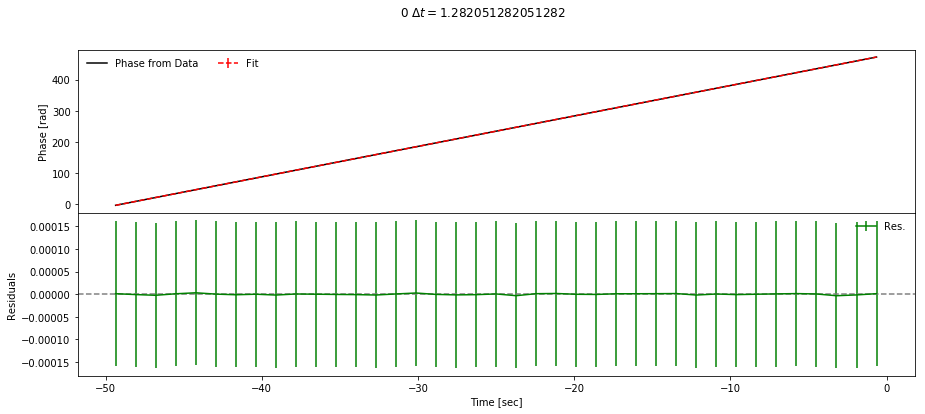

In [8]:
for i in range(len(phi_arr_all)):
    mpl.rcParams['figure.figsize'] = [15.0, 6.0]
    f, ax_arr = plt.subplots(2, 1)
    f.suptitle(str(k_ind)+' $\Delta t = '+str(delta_t)+"$")
    ax_arr[0].plot( times, phi_arr_all[i], c="black", label="Phase from Data")
    ax_arr[0].errorbar( times, phi_fitresults_arr[i], (phi_fiterr_arr[i][1]+phi_fiterr_arr[i][0]*times), c="red", ls="--", label="Fit")
    ax_arr[1].errorbar( times, (phi_arr_all[i] - phi_fitresults_arr[i]), phi_err_all[i], c="green", label="Res.")
    ax_arr[1].axhline(0, ls="--", c="grey")
    ax_arr[0].legend(frameon=False, ncol=2 )
    ax_arr[1].legend(frameon=False, ncol=2 )
    ax_arr[1].set_xlabel("Time [sec]")
    ax_arr[0].set_ylabel("Phase [rad]")
    ax_arr[1].set_ylabel("Residuals")
    f.subplots_adjust(hspace=0)

In [9]:
print(np.mean(chi2_arr))

8.451536576902995e-05
